# Hand Gesture Recognition Model

***Problem Statement***: Predict the given hand gesture image

***Dataset***: Hand gesture recognition database is presented, composed by a set of near infrared images acquired by the Leap Motion sensor. The database is composed by 10 different hand-gestures (showed above) that were performed by 10 different subjects (5 men and 5 women).

The database is structured in different folders as:

* /00 (subject with identifier 00)
     1. /01_palm (images for palm gesture of subject 00 )
        * /01_palm/frame_197957_r.png,…,frame_198136_l.png, … (images that corresponds to different samples obtained for the palm gesture performed by the subject with identifier 00)
     2. /02_l (images for l gesture of subject 00 )
     3. /10_down
* /01
* /02
* /09 (last subject with identifier 09)

Every root folder (00, 01,…) contains the infrared images of one subject. The folder name is the identifier of each different subject.

***Methodology***:

The following steps are adapted to perform the prediction:

1. Import the necessary libraries
2. Data Collection and Exploration
3. Data Visualization
4. Data Preprocessing
5. Model Building
6. Model Evaluation

### a. Import the necessary libraries

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2 
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

### b. Data Collection and Exploration

In [2]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('../input/leapgestrecog/leapGestRecog/00/'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'02_l': 0,
 '04_fist_moved': 1,
 '09_c': 2,
 '10_down': 3,
 '06_index': 4,
 '08_palm_moved': 5,
 '07_ok': 6,
 '05_thumb': 7,
 '01_palm': 8,
 '03_fist': 9}

As described in the Data Overview, there are 10 folders labelled 00 to 09, each containing images from a given subject. In each folder there are subfolders for each gesture. 

* *lookup* stores names of gestures we need to identify
* *reverselookup* tells us what gesture is associated to a given identifier.

In [3]:
# Loading the images and their class(0 - 9)
CATEGORIES = list(lookup.keys())
IMG_SIZE = 50
data_path = "../input/leapgestrecog/leapGestRecog"
image_data = []
for dr in os.listdir(data_path):
    for category in CATEGORIES:
        class_index = CATEGORIES.index(category)
        path = os.path.join(data_path, dr, category)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                image_data.append([cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)), class_index])
            except Exception as e:
                pass
image_data[0]

[array([[6, 6, 6, ..., 4, 4, 5],
        [5, 6, 6, ..., 3, 5, 4],
        [6, 6, 7, ..., 4, 4, 4],
        ...,
        [6, 7, 6, ..., 5, 4, 4],
        [7, 6, 6, ..., 5, 4, 5],
        [5, 6, 7, ..., 4, 5, 4]], dtype=uint8),
 0]

In [4]:
# shuffle the input data
import random
random.shuffle(image_data)

In [5]:

input_data = []
label = []
for X, y in image_data:
    input_data.append(X)
    label.append(y)
    
label[:10]

[7, 7, 3, 6, 8, 4, 0, 6, 2, 1]

* *input_data* stores images
* *label* stores numerical classifier for each image

### c. Data Visualization

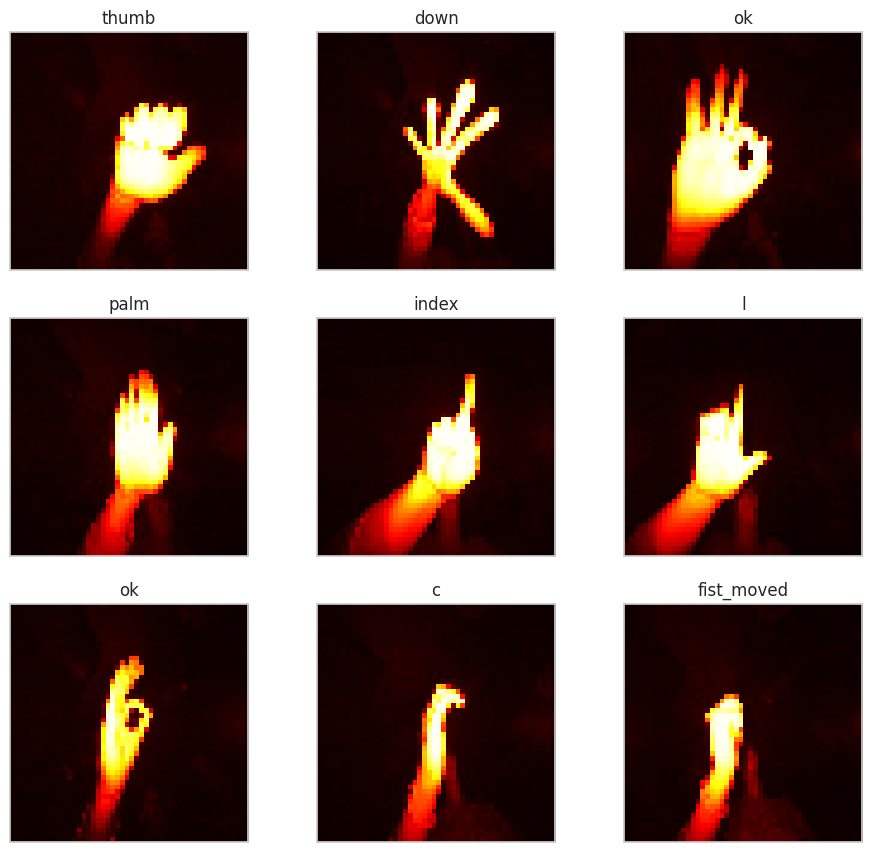

In [6]:
plt.figure(1, figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(image_data[i][0], cmap='hot')
    plt.xticks([])
    plt.yticks([])
    plt.title(CATEGORIES[label[i]][3:])
plt.show()

### d. Data Preprocessing

In [7]:
# Normalizing the data
input_data = np.array(input_data)
label = np.array(label)
input_data = input_data/255.0
input_data.shape

(20000, 50, 50)

In [8]:
# one hot encoding
label = keras.utils.to_categorical(label, num_classes=10,dtype='i1')
label[0]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int8)

In [9]:
# reshaping the data
input_data.shape = (-1, IMG_SIZE, IMG_SIZE, 1)

In [10]:
# splitting the input_data to train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_data, label, test_size = 0.3, random_state=0)

In [11]:
print('Train data    :'+str(X_train.shape))
print('Test data     :'+str(X_test.shape))
print('Train Output  :'+str(y_train.shape))
print('Test Output   :'+str(y_test.shape))

Train data    :(14000, 50, 50, 1)
Test data     :(6000, 50, 50, 1)
Train Output  :(14000, 10)
Test Output   :(6000, 10)


### e. Model Building

In [12]:
# Define model
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10, activation = "softmax"))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 96)          0

In [14]:
# Train the model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
History = model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
219/219 [==============================] - 14s 11ms/step - loss: 0.6354 - accuracy: 0.7893 - val_loss: 0.1110 - val_accuracy: 0.9623
Epoch 2/10
219/219 [==============================] - 2s 8ms/step - loss: 0.0598 - accuracy: 0.9843 - val_loss: 0.2864 - val_accuracy: 0.9283
Epoch 3/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0298 - accuracy: 0.9936 - val_loss: 0.0281 - val_accuracy: 0.9888
Epoch 4/10
219/219 [==============================] - 2s 8ms/step - loss: 0.0127 - accuracy: 0.9966 - val_loss: 8.7084e-04 - val_accuracy: 1.0000
Epoch 5/10
219/219 [==============================] - 2s 8ms/step - loss: 0.0128 - accuracy: 0.9979 - val_loss: 5.3324e-04 - val_accuracy: 1.0000
Epoch 6/10
219/219 [==============================] - 2s 8ms/step - loss: 0.0134 - accuracy: 0.9970 - val_loss: 0.0016 - val_accuracy: 0.9995
Epoch 7/10
219/219 [==============================] - 2s 8ms/step - loss: 1.3920e-04 - accuracy: 1.0000 - val_loss: 2.5649e-04 - val_accur

### f. Model Evaluation

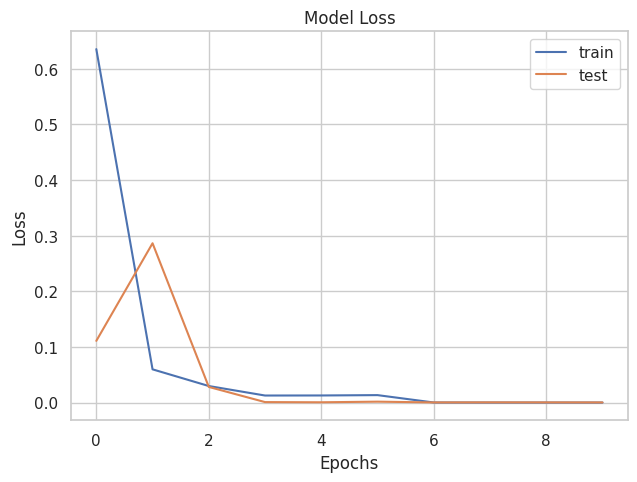

In [15]:
# Plot Loss for training and testing
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

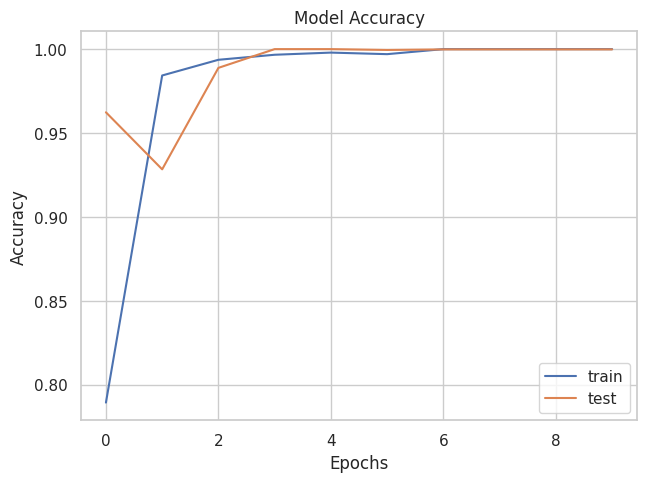

In [16]:
# Plot Accuracy for training and testing
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

188/188 [==============================] - 1s 2ms/step
Confusion Matrix:



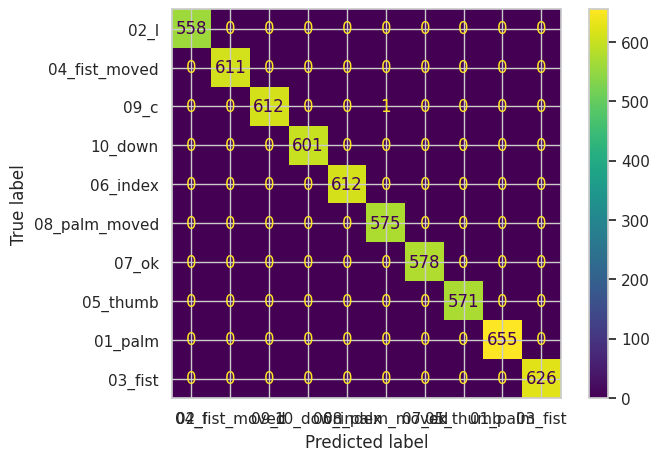

In [17]:
# Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
print("Confusion Matrix:\n")

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=CATEGORIES)
disp.plot(cmap='viridis', values_format='d')
plt.show()

In [18]:
#calculate loss and accuracy on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test accuracy: {:2.2f}%'.format(test_accuracy*100))

188/188 [==============================] - 1s 3ms/step - loss: 2.5468e-04 - accuracy: 0.9998
Test accuracy: 99.98%
